In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from helpers.utilities import *

In [2]:
from os import chdir
chdir('..')

In [3]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

# Protein levels - unsupervised analyses

Please refer to [Protein_data_QC_and_transforms](Protein_data_QC_and_transforms.ipynb) for introduction to SOMAscan, introductory discussion on transformations and data quality checks.

In [4]:
protein_levels = read_csv('data/clean/protein/levels.csv', index_col=[0,1,2,3])

## Clustering

Keep "target" as unique index:

In [5]:
matrix = protein_levels.reset_index(level=['target_full_name', 'entrez_gene_symbol', 'soma_id'], drop=True)

In [6]:
clinical_data = read_csv('data/clean/clinical/data.csv', index_col=0)

In [7]:
clinical_for_protein_study = clinical_data.loc[protein_levels.columns]

In [8]:
clinical_ordered = clinical_for_protein_study.loc[matrix.columns]
set(clinical_ordered.condition)

{'CM', 'HC', 'TMD', 'TMR', 'TMS', 'VM'}

#### For easy interpretation of patient clusters:

In [9]:
from plots.annotations import conditions_names, tuberculosis_status

In [10]:
patient_annotations = DataFrame({
    'Meningitis': clinical_ordered.condition.replace(conditions_names),
    'Tuberculosis status': clinical_ordered.condition.map(tuberculosis_status).fillna('-'),
    'HIV status': clinical_ordered.HIVResult
})

In [11]:
%R source('plots/colors.R');

In [12]:
%%R -i matrix -i patient_annotations
library(pheatmap)

colnames(matrix) <- sub('^X', '', colnames(matrix))
rownames(patient_annotations) <- colnames(matrix)
names(patient_annotations) <- sub('\\.', ' ', names(patient_annotations))

### First look at the data

Simple clustering with log10-transformation and defaults (linkage=complete, distance=euclidean) to get an overview of the data:

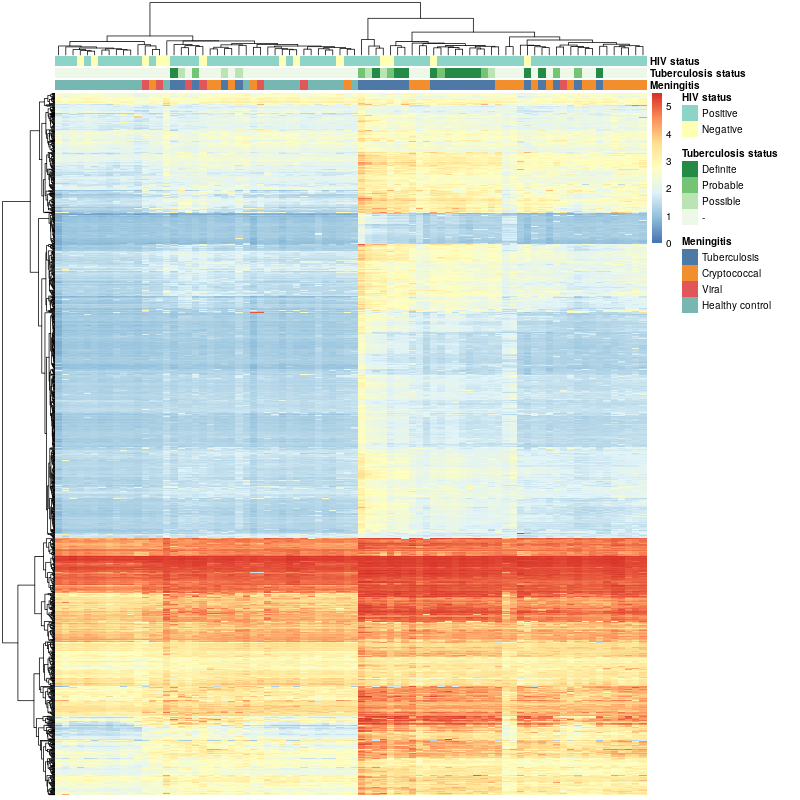

In [13]:
%%R -w 800 -h 800 -u px
pheatmap(
    log10(matrix),
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors
)

Z-score, protein-wise (log10 transform skipped on purpose):

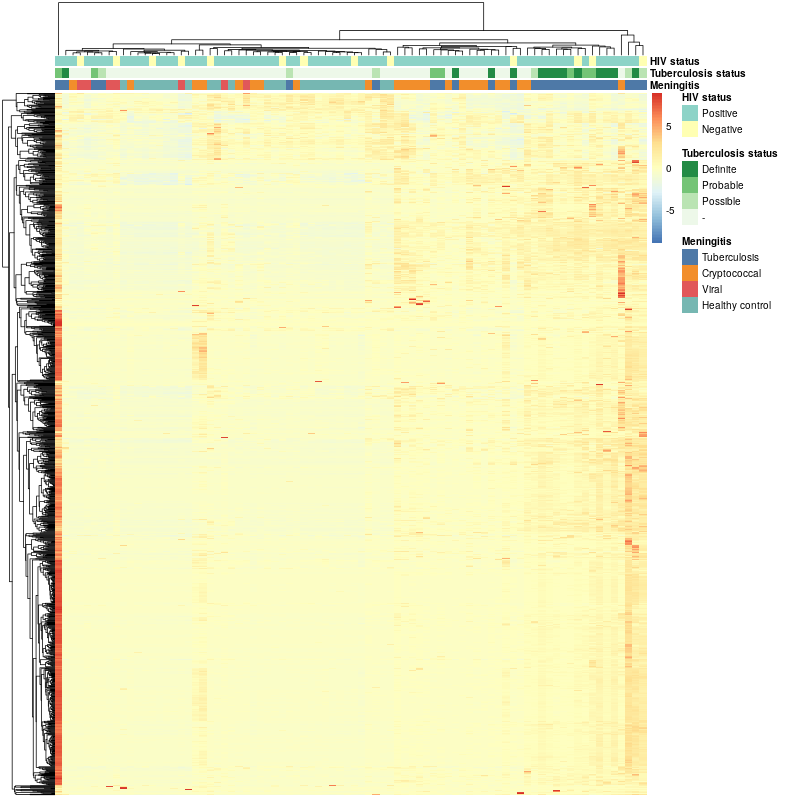

In [14]:
%%R -w 800 -h 800 -u px
pheatmap(
    matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='row' # this enables z-score, row-wise
)

Regardless of transformation:
- The clustering looks nice! Many tuberculosis patients are in the same cluster, similarly the cryptococcal patients. There is some overlap.
- No clear clustering by HIV status

Log-10 transformation highlights:
- Seems to place all the healthy controls on the left cluster and most of the meningitis patients to the right cluster.  

The z-score transformation highlights that:
- One patient is an outlier, with values much higher than average for most genes.

The outlier patient is:

In [15]:
matrix.mean().argmax()

'024.TMR'

### Choosing linkage method and distance

- Definitely not "single" linkage, prefer "complete" over "average" [(D'haeseleer, 2005)](https://www.nature.com/articles/nbt1205-1499)
- Ward linkage and Pearson correlation distance may be better for proteomics data [(Meunier, 2007)](https://pubs.acs.org/doi/full/10.1021/pr060343h)

My intuition for the distance function choice:
- Pearson correlation will tend to group together patients with similar patterns of relative protein abundances
- Euclidean distance will tend to group together patients with similar levels of proteins, giving less weight to the distribution patterns

Thus correlation may "correct" for the technical variation in samples.

NB: there is some discussion regarding the use of distance measures other than euclidean for ward's method. Revisit later?

I will continue to use log transformation:

In [16]:
from numpy import log10

In [17]:
log_matrix = matrix.applymap(log10)

But will refrain from any further transformations for now.

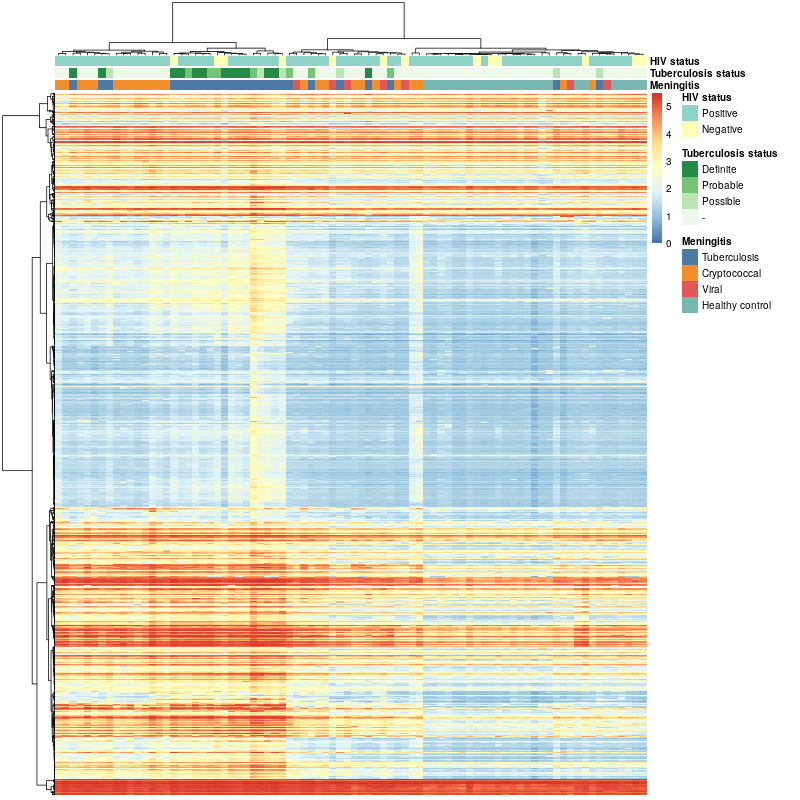

In [18]:
%%R -w 800 -h 800 -u px -i log_matrix -o log_clusters
colnames(log_matrix) <- sub('^X', '', colnames(log_matrix))

log_clusters = pheatmap(
    log_matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='none',
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation'
)

### Further attempts to normalize/transform

Some thoughts on transformations:
- we may suspect that there will be less proteins in the healthy controls,
    - we could control for that if the goal is to elucidate differences in the immune system proxies or look for specific biomarkers (i.e. what immune-response related proteins are more often active in the CSF when compared against the background)
    - but not controlling is a real-life scenario: the mere fact of detecting much more proteins than expected might be used to help diagnose the patient
- log transformation reduces the problem of high dynamic range. However, it also over-emphasizes the proteins with very low levels [(Berg et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1534033/) / common knowledge.
- z-score appears to be well suited for distributions closer to the normal family - as it uses mean and standard deviation
- it might be better to use the more robust median rather than mean as it is less prone to outliers [(Berg et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1534033/) / common knowledge. However, log-transformation partially alleviates this problem (and there is little precedent such approach)
- I would be tempted to use an advanced transformation followed by scaling, though there is little precedent in the field. Also, this would reduce the ease of interpretation of results (everyone understands log-transform, but not necessarily Box-Cox)

A [review of HCA for proteomic data](https://pubs.acs.org/doi/full/10.1021/pr060343h) mentions an alternative being division by maximum value of each sample - I would not do that as this procedure may susceptible to outliers, though they demonstrate that it gives better results than z-score (though not on SOMAscan data which has greater dynamic range).

I propose to follow the log-transformation with:
 - z-score on samples (patients) - to address the issue of some samples having more proteins than others (which could be either technical or biological) - see 024.TMR (NB: the above discussed issue of the relative levels being potentially diagnostic is not necessarily important: confirming that more proteins in CSF may imply greater chance of a disease is not necessarily novel neither ambitious - I could just do a separate analysis for that); I could use modified z-score with median instead of mean (Iglewicz-Hoaglin) - though it does not seem to be necessary
 - z-score normalization of each feature (protein)

In [19]:
def z_score(v):
    return (v - v.mean()) / v.std()

In [20]:
z_log_matrix = log_matrix.apply(z_score).apply(z_score, axis=1)

Note: after such transformation, the per-patient variance is not equal to one (though it is alleviated by centering and scaling again in the PCA procedure and by use of correlation distance in HCA).

In [21]:
variance_by_patient = log_matrix.apply(z_score).apply(z_score, axis=1).var().reset_index()
variance_by_patient.columns = ['patient', 'variance']

In [22]:
df = variance_by_patient.merge(patient_annotations, left_on='patient', right_index=True)

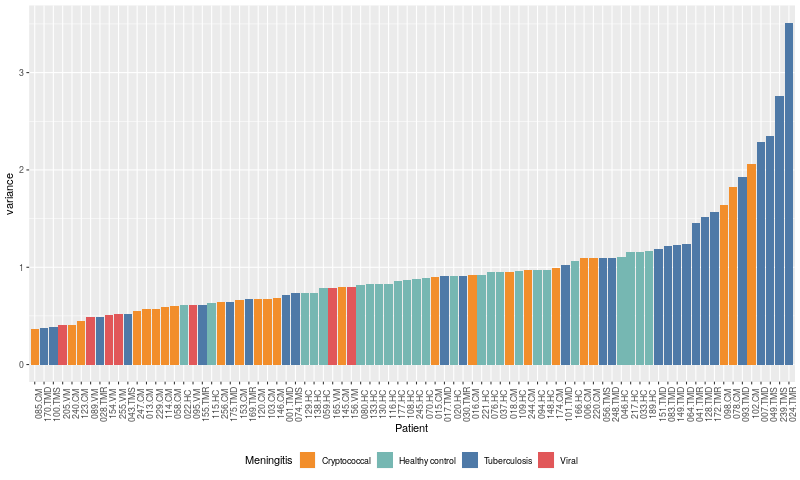

In [23]:
%%R -i df -w 800 -u px
(
    ggplot(df, aes(x=reorder(patient, variance), y=variance, fill=Meningitis))
    + geom_bar(stat='identity')
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(axis.text.x=element_text(angle=90), legend.position='bottom')
    + xlab('Patient')
)

While z-score transformation of one axis (patients/proteins) would not change the clustering when the distance function is correlation, it is not true for clustering on the other axis (as it is not centered/scaled, see the picture above). Thus z-transformation may change the clustering results.

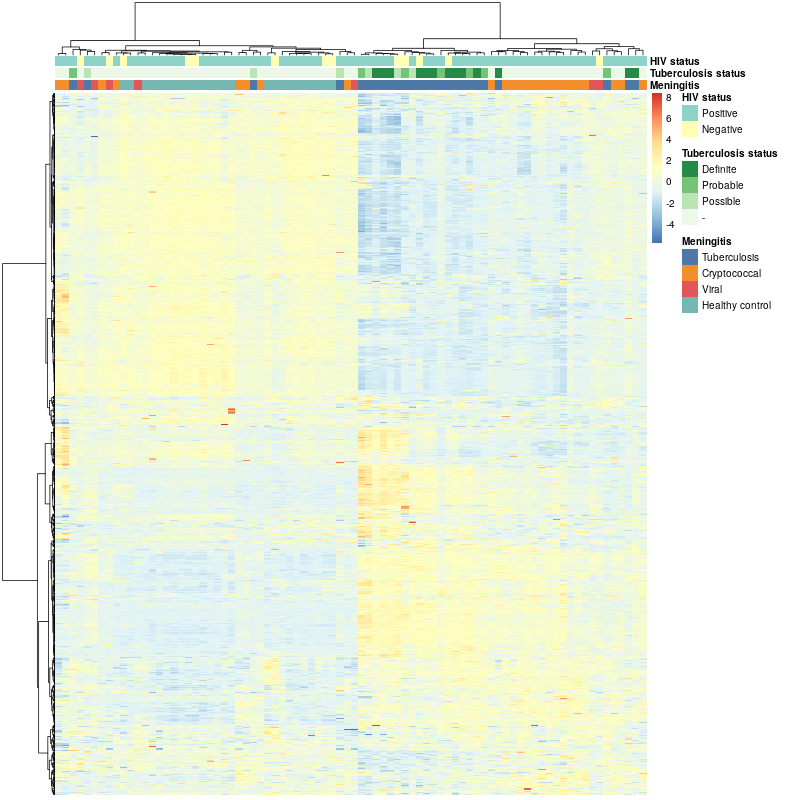

In [24]:
%%R -w 800 -h 800 -u px -i z_log_matrix -o z_log_clusters
colnames(z_log_matrix) <- sub('^X', '', colnames(z_log_matrix))

z_log_clusters = pheatmap(
    z_log_matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='none',
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation'
)

As the patient clustering is visibly good enough as for the initial analysis, I will stop here.

An alternative would be to explore top-bottom clustering as an addition.

### Analysis - patient clustering

In [25]:
%%R
library('factoextra');

R[write to console]: Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ



In [26]:
%%R
# these are simply hclust results
log_patient_clusters = log_clusters$tree_col
z_log_patient_clusters = z_log_clusters$tree_col

#### Log-transformed

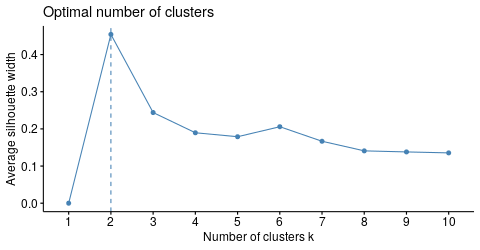

In [27]:
%%R -h 250 -u px
fviz_nbclust(
    t(log_matrix), # transpose to cluster patients, not proteins
    hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2'
)

I will ignore the suggestion of selecting two clusters - we know that there are at least four distinct patient groups. I do not show plots for elbow method/RSS as these have the same issue.

I will choose $k=6$ for the log-transformed clustering as there is a visible drop at $k=$ (and we want $k>=4$).

In [28]:
%%R
log_subgroups = cutree(log_patient_clusters, 6)

Simple PCA visualization:

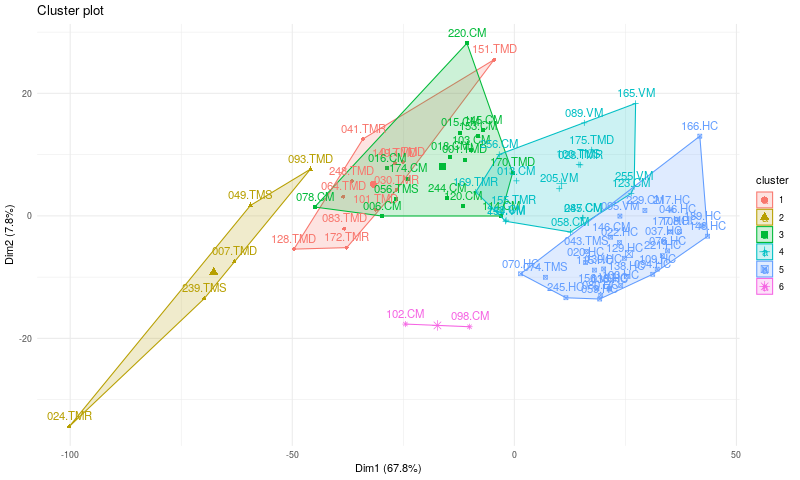

In [29]:
%%R -w 800 -u px
fviz_cluster(list(data=t(log_matrix), cluster=log_subgroups)) + theme_minimal()

Well, the data was not normalized.

#### Log-z-transformed "normalized"

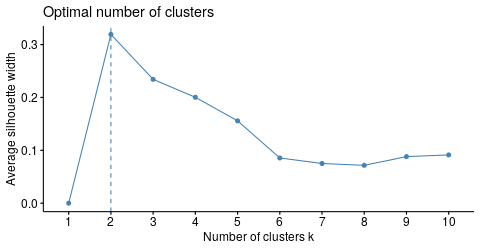

In [30]:
%%R -h 250 -u px
fviz_nbclust(t(z_log_matrix), hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2')

I will choose $k = 4$ as it is the minimal assumed number of clusters.

In [31]:
%%R
z_log_subgroups = cutree(z_log_patient_clusters, 4)

Simple PCA

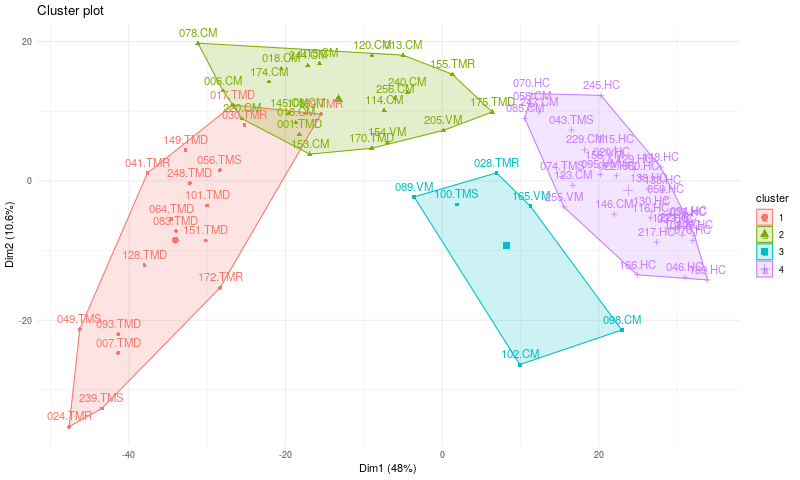

In [32]:
%%R -w 800 -u px
fviz_cluster(list(data=t(z_log_matrix), cluster=z_log_subgroups)) + theme_minimal()

#### Z-score vs log-transform only?

In [33]:
%%R 
suppressPackageStartupMessages(library(dendextend));

The clusterings are visibly different, even after untangling:

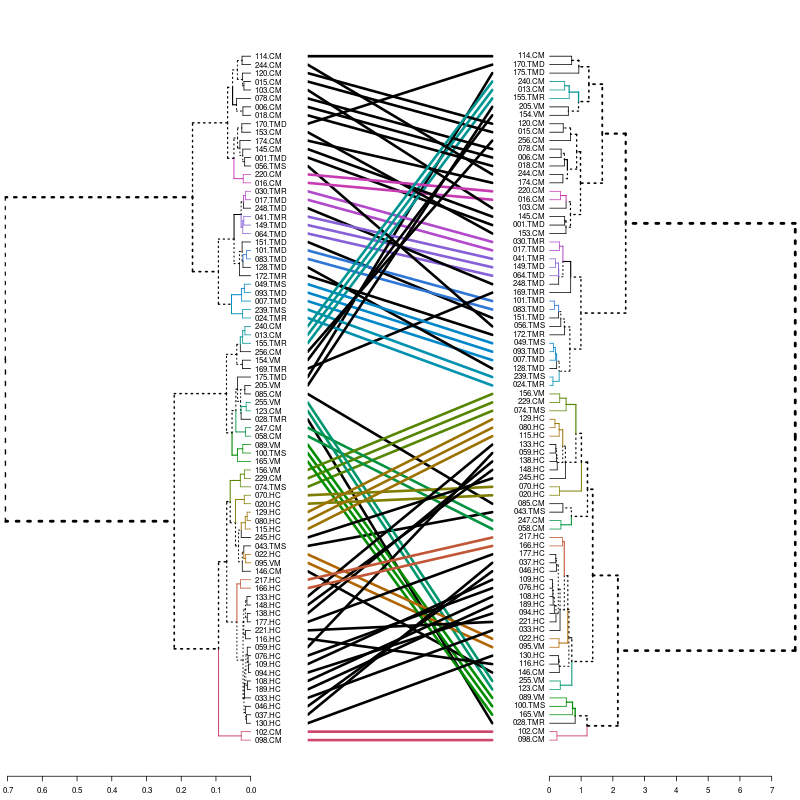

In [34]:
%%R -w 800 -h 800 -u px
patient_clusterings = dendlist(
    as.dendrogram(log_patient_clusters),
    as.dendrogram(z_log_patient_clusters)
)

tanglegram(
    untangle(patient_clusterings, method="step1side"),
    common_subtrees_color_branches=T,
    margin_inner=6,
    highlight_distinct_edges=T,
)

### Analysis - protein clustering

In [35]:
%%R
log_protein_clusters = log_clusters$tree_row
z_log_protein_clusters = z_log_clusters$tree_row

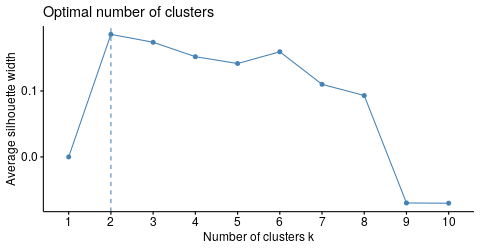

In [36]:
%%R -h 250 -u px
fviz_nbclust(log_matrix, hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2', nboot = 500)

Average silhouette is visibly lower.

Using $k=4$.

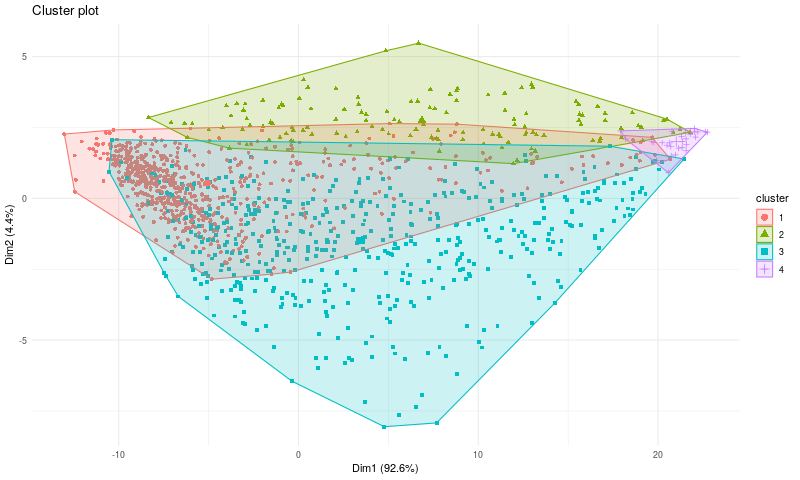

In [37]:
%%R -w 800 -u px
log_subgroups = cutree(log_protein_clusters, 4)
fviz_cluster(list(data=log_matrix, cluster=log_subgroups), geom='point') + theme_minimal()

#### Log-z-transformed "normalized"

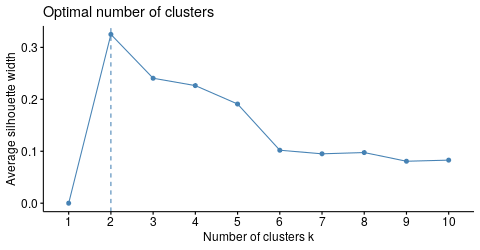

In [38]:
%%R -h 250 -u px
fviz_nbclust(z_log_matrix, hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2')

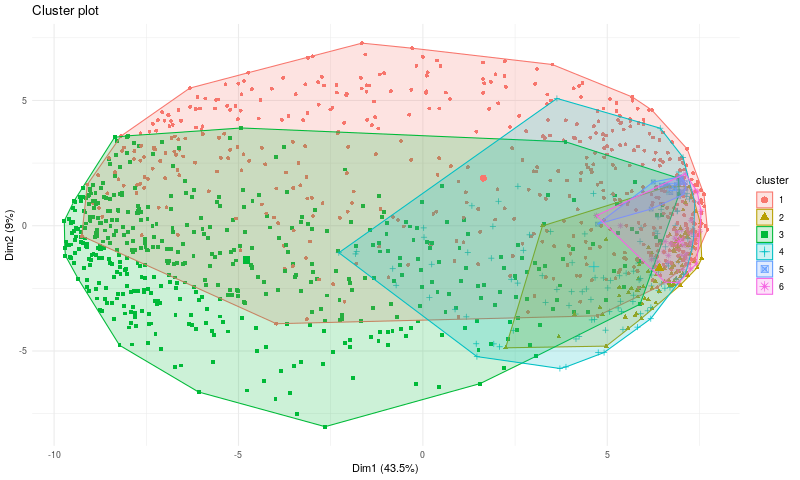

In [39]:
%%R -w 800 -u px
z_log_subgroups = cutree(log_protein_clusters, 6)
fviz_cluster(list(data=z_log_matrix, cluster=z_log_subgroups), geom='point') + theme_minimal()

### Summary

TODO: Compare the clusterings with alluvial/different metrics?

### PCA

In [40]:
%%R -o pca
# scale=F would be almost* an equivalent (as I scaled the data beforehand);
# scale=T signals to the fviz package that I want to show the correlation circle
# *almost = the final transformation was z-score scaling on proteins, not patients
# (which was also performed, but earilier) so it is not an exact equivalence.
pca = prcomp(t(z_log_matrix), scale=T)

Eigenvalues:

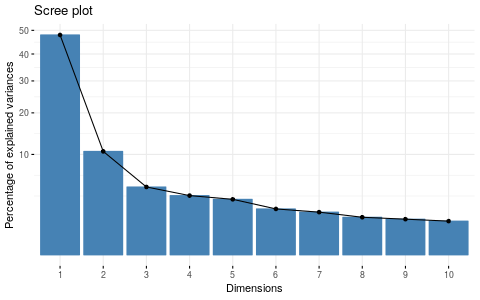

In [41]:
%%R -h 300 -u px
fviz_eig(pca) + scale_y_sqrt()

82 principal components as we have 82 patients with protein data:

In [42]:
%%R -h 300 -u px -o variance_explained_df
variance_explained_df = get_eig(pca)
variance_explained_df$PC = rownames(variance_explained_df)

In [43]:
variance_explained_df.PC = variance_explained_df.PC.str[4:] # remove the "Dim." prefix
variance_explained_df.PC = pd.Categorical(variance_explained_df.PC, ordered=True, categories=variance_explained_df.PC)

In [44]:
%R source('plots/pca.R');

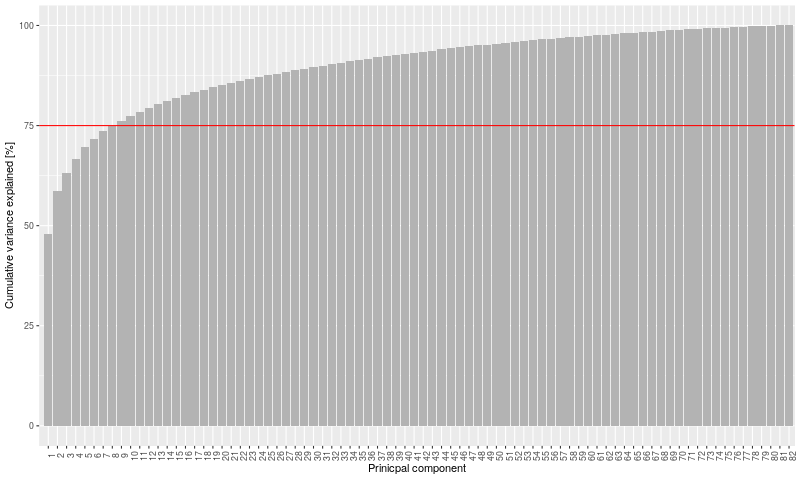

In [45]:
%%R -i variance_explained_df -w 800 -u px
cumulative_variance_explained(
    variance_explained_df,
    threshold=75 # chosen to be above >50, <100 and to get a reasonable
                 # (not too large) number of PCs to analyze
)

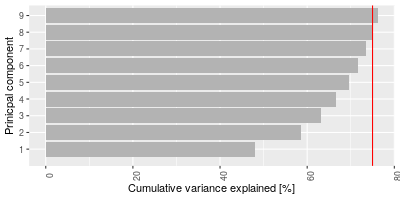

In [46]:
%%R -w 400 -h 200 -u px
(
    cumulative_variance_explained(
        variance_explained_df[variance_explained_df$PC<10,],
        threshold=75
    )
    + coord_flip()
)

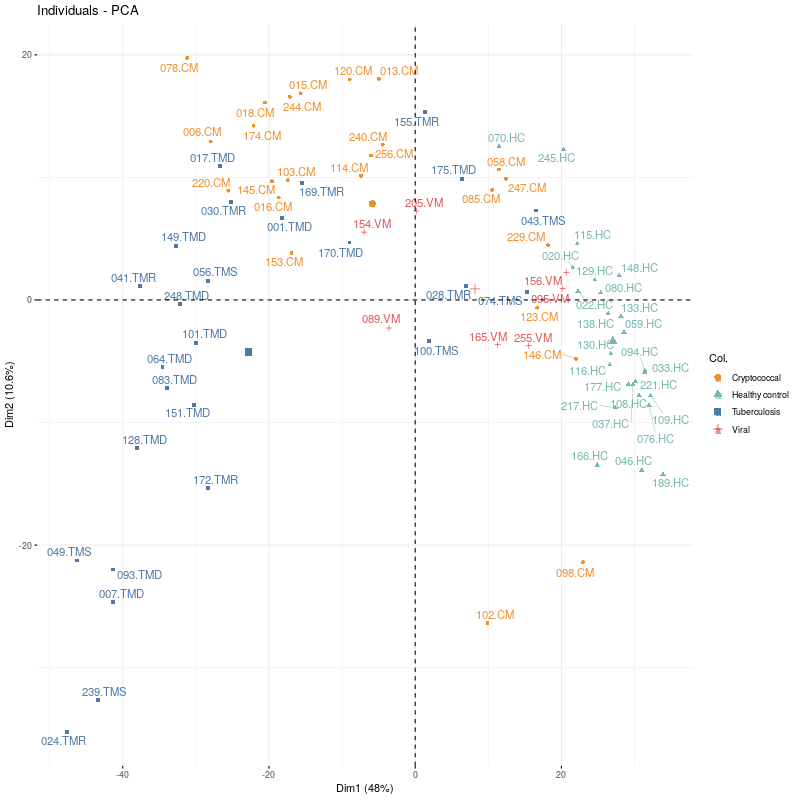

In [47]:
%%R -w 800 -h 800 -u px
fviz_pca_ind(
    pca,
    repel=T,
    col.ind=patient_annotations$Meningitis,
    palette=patient_colors$Meningitis
)

Roughly, both PC1 and PC2 separate the groups of interest:
- PC1 placing healthy controls on the right (high, positive values) and diseased patients on the left
- PC2 placing most of the cryptoccocal patients on the top (positive values) while many TB patients below

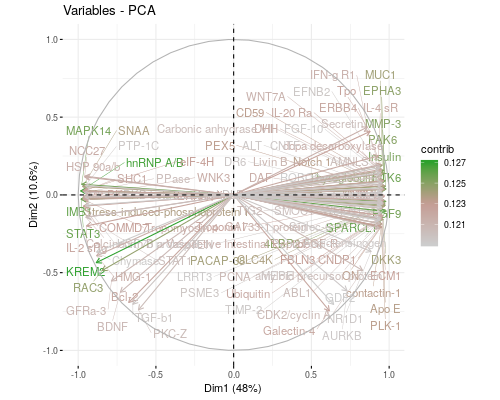

In [48]:
%%R -w 500 -h 400 -u px
    fviz_pca_var(
    pca, repel=T,
    col.var="contrib",
    gradient.cols=c("#cccccc", "#c49c94", "#2CA02C"),
    select.var=list(contrib=100)
)

Selecting variables by contribution (which is scaled to the importance of a principal component) shows only the variables contributing to PC1.

To overcome this limitation and make the plot more readable, I select top 20 variables contributing the most to each of the principal components (ignoring the weighted contributions suggested by the R package):

Please see [Notes_on_PCA_with_prcomp_and_factoextra.ipynb](Notes_on_PCA_with_prcomp_and_factoextra.ipynb) for more detailed discussion.

In [49]:
from helpers.unsupervised import top_variables

In [50]:
%%R -o loadings
loadings = as.data.frame(pca$rotation)

In [51]:
selected_proteins = [
    protein
    for pc in ['PC1', 'PC2']
    for protein in top_variables(loadings, pc, n=50).index
]

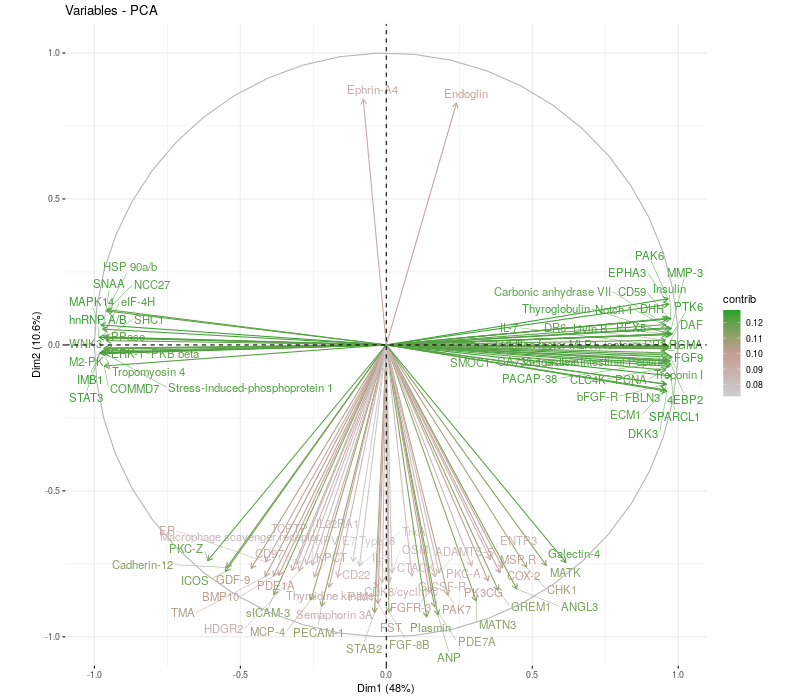

In [52]:
%%R -w 800 -h 700 -u px -i selected_proteins
    fviz_pca_var(
    pca, repel=T,
    col.var="contrib",
    gradient.cols=c("#cccccc", "#c49c94", "#2CA02C"),
    select.var=list(name=selected_proteins)
)

### Increasing interpretability - gene ontology analysis

In [53]:
%%R
small_heatmap = function(matrix) {
    colnames(matrix) <- sub('^X', '', colnames(matrix))
    pheatmap(
        matrix,
        show_colnames=FALSE,
        annotation_col=patient_annotations,
        annotation_colors=patient_colors,
        border_color='grey70',
        scale='row'
    )
}

#### Gene ontology enrichment

I will highlight proteins of genes associated with major biological processes of the cell.

I use Gene Ontology (though it is less specific than let say PRO - a protein ontology) as it is an established standard and "behaves well". I can change it to use another ontology if you wish to proceed with this kind of analyses.

To get curated GO-protein associations for UniProt accessions I use [GOA from EBI](https://www.ebi.ac.uk/GOA).

In [54]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/HUMAN/goa_human.gaf.gz -N -q
!gunzip goa_human.gaf.gz -q -f

In [55]:
from goatools.associations import read_gaf
from goatools.obo_parser import GODag
from goatools.base import download_go_basic_obo

download_go_basic_obo();

  EXISTS: go-basic.obo


In [56]:
from helpers.ontology import ProteinOntologyClassifier

In [57]:
classifier = ProteinOntologyClassifier(
    ontology=GODag("go-basic.obo"),
    associations=read_gaf('goa_human.gaf')
)

go-basic.obo: fmt(1.2) rel(2019-03-19) 47,381 GO Terms
  READ      476,723 associations: goa_human.gaf


In [58]:
relevant_aptamers = read_csv('data/other/relevant_aptamers.csv')

In [59]:
processes = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='biological_process'
)

What are the common/rare processes?

As we analyze only a fraction of the proteome, the analyzed proteins may over-represent certain processes.

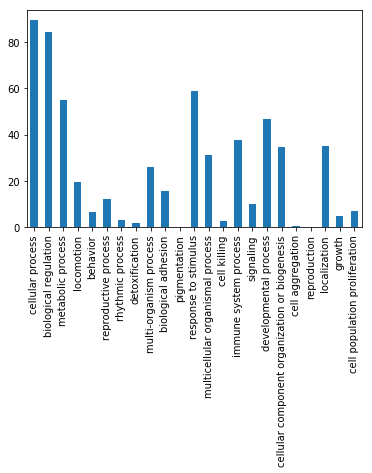

In [60]:
measured_proteins_with_process_ratio = (processes.sum() / len(processes) * 100)
measured_proteins_with_process_ratio.plot(kind='bar');

#### Major biological processes

In [61]:
from helpers.ontology import transform_to_classes

In [62]:
processes_matrix = transform_to_classes(z_log_matrix, processes)

Going to loose signal from 4.52% (59) proteins


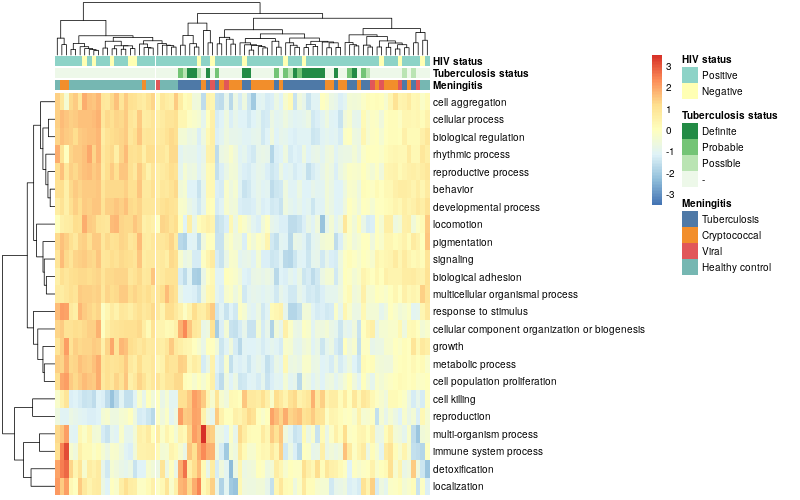

In [63]:
%%R -w 800 -h 500 -u px -i processes_matrix
small_heatmap(processes_matrix)

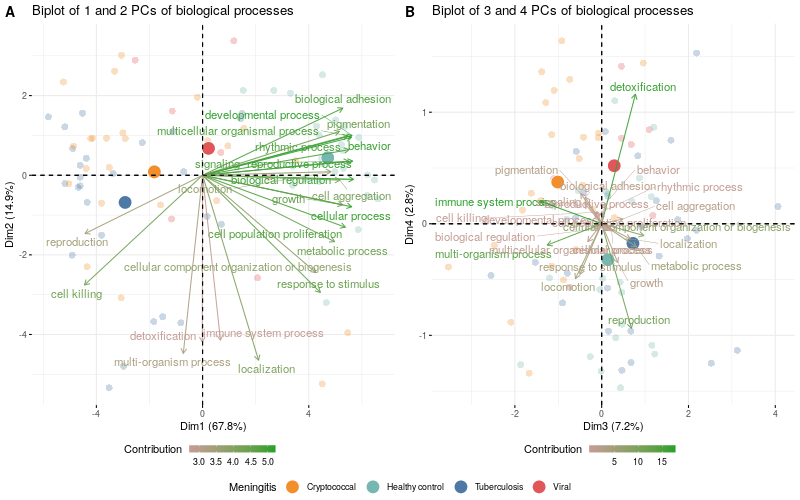

In [64]:
%%R -w 800 -h 500 -u px
first_four_pcs(processes_matrix, 'biological processes')

#### Molecular functions

In [65]:
functions = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='molecular_function'
)
functions_matrix = transform_to_classes(z_log_matrix, functions)

Going to loose signal from 6.05% (79) proteins


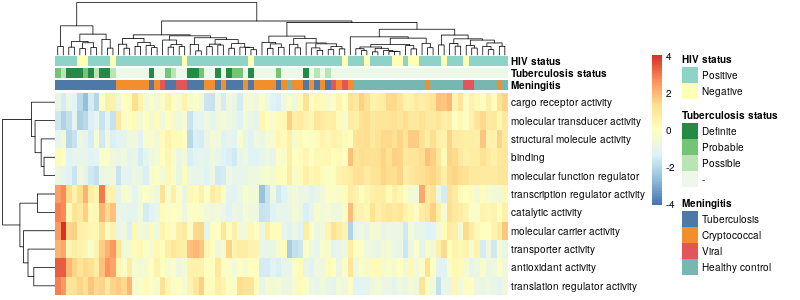

In [66]:
%%R -w 800 -h 300 -u px -i functions_matrix
small_heatmap(functions_matrix)

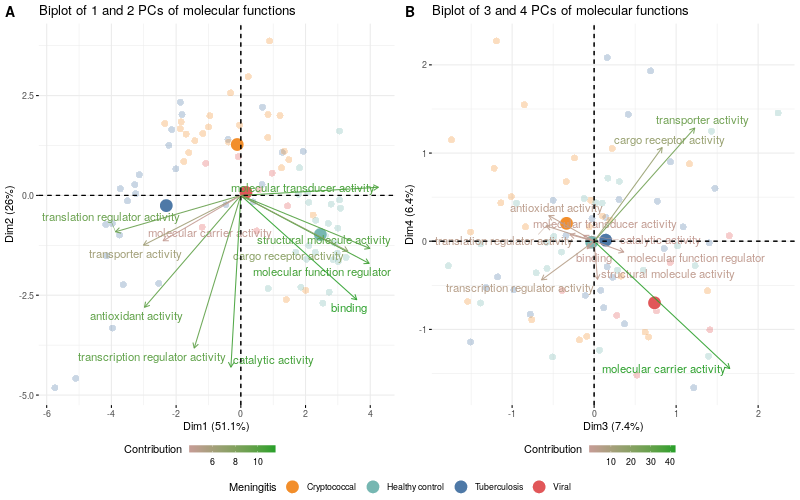

In [67]:
%%R -w 800 -h 500 -u px
first_four_pcs(functions_matrix, 'molecular functions')

#### Cellular components

In [68]:
components = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='cellular_component'
)
components_matrix = transform_to_classes(z_log_matrix, components)

Going to loose signal from 5.44% (71) proteins


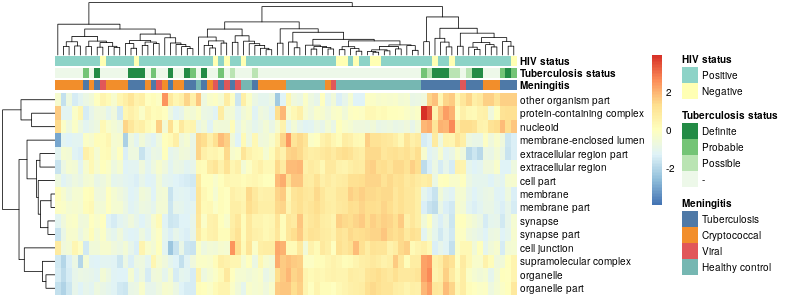

In [69]:
%%R -w 800 -h 300 -u px -i components_matrix
small_heatmap(components_matrix)

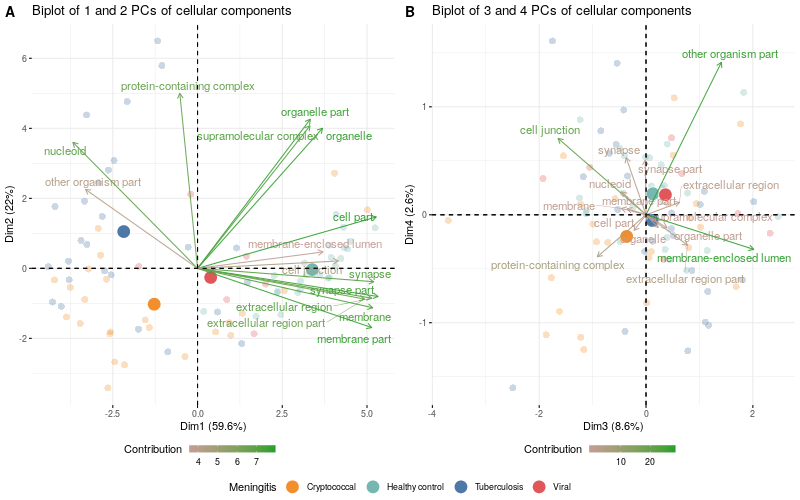

In [70]:
%%R -w 800 -h 500 -u px
first_four_pcs(components_matrix, 'cellular components')

Given little viral proteins and no bacterial proteins presence of nucleoid is a bit surpising. What proteins are in there?

In [71]:
list(components[components.nucleoid == True].index)

['ATP synthase beta chain']

Just one!

In [72]:
relevant_aptamers.query('Target == "ATP synthase beta chain"').UniProt

234    P06576
Name: UniProt, dtype: object

So here "nucleoid" refers to a region of human mitochondrium!